<a href="https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/4_NormalizationInsideNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import libraries**

In [11]:
import random
import matplotlib.pyplot as plt # truc quan hoa
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import FashionMNIST #download fashion mnist data


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

cpu


## **1. Prepare dataset**


In [4]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.66MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 135kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.52MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.2MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## **2. Build MLP network with `Normalization: BatchNorm `**




In [5]:
train_ratio = 0.9
# train_size là số lượng mẫu dữ liệu dùng để train (54000 mẫu = 90% của tập train_dataset)
train_size = int(train_ratio * len(train_dataset)) #90%
val_size = len(train_dataset) - train_size #10%

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 512
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


In [6]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.bn1 = nn.BatchNorm1d(hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.bn2 = nn.BatchNorm1d(hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.bn3 = nn.BatchNorm1d(hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.bn4 = nn.BatchNorm1d(hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.bn5 = nn.BatchNorm1d(hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.bn6 = nn.BatchNorm1d(hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.bn7 = nn.BatchNorm1d(hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.05)
        nn.init.constant_(m.bias, val=0.0)

  def forward(self, x):
    x = nn.Flatten()(x)

    x = self.layer1(x)
    x = self.bn1(x)
    x = nn.Sigmoid()(x)

    x = self.layer2(x)
    x = self.bn2(x)
    x = nn.Sigmoid()(x)

    x = self.layer3(x)
    x = self.bn3(x)
    x = nn.Sigmoid()(x)

    x = self.layer4(x)
    x = self.bn4(x)
    x = nn.Sigmoid()(x)

    x = self.layer5(x)
    x = self.bn5(x)
    x = nn.Sigmoid()(x)

    x = self.layer6(x)
    x = self.bn6(x)
    x = nn.Sigmoid()(x)

    x = self.layer7(x)
    x = self.bn7(x)
    x = nn.Sigmoid()(x)

    out = self.output(x)
    return out

In [7]:
input_dims = 784 #28x28 pixel = 784 pixel
hidden_dims = 128
output_dims = 10 #10 class
lr = 1e-2
model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **3. Training**

In [8]:
epochs = 100
train_loss_list =[]
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
  train_loss = 0
  train_acc = 0
  count = 0
  model.train()
  for X_train, y_train in train_loader:
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()

    outputs = model(X_train)

    loss = criterion(outputs, y_train)

    loss.backward()
    # Update weight, bias
    optimizer.step()

    train_loss += loss.item()
    train_acc += (torch.argmax(outputs,1) == y_train).sum().item()
    count += len(y_train)

  train_loss /= len(train_loader)
  train_loss_list.append(train_loss)
  train_acc /= count
  train_acc_list.append(train_acc)

  val_loss = 0.0
  val_acc = 0.0
  count = 0

  model.eval()
  with torch.no_grad():
    for X_val, y_val in val_loader:
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      outputs = model(X_val)
      loss = criterion(outputs, y_val)
      val_loss += loss.item()
      val_acc += (torch.argmax(outputs,1) == y_val).sum().item()
      count += len(y_val)

  val_loss /= len(val_loader)
  val_loss_list.append(val_loss)
  val_acc /= count
  val_acc_list.append(val_acc)

  print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f},Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f} , Val_Acc:{val_acc:.4f}")

EPOCH 1/100, Train_Loss: 1.9205,Train_Acc: 0.5561, Validation Loss: 1.6695 , Val_Acc:0.6837
EPOCH 2/100, Train_Loss: 1.5195,Train_Acc: 0.7094, Validation Loss: 1.4012 , Val_Acc:0.7178
EPOCH 3/100, Train_Loss: 1.2997,Train_Acc: 0.7371, Validation Loss: 1.2240 , Val_Acc:0.7420
EPOCH 4/100, Train_Loss: 1.1444,Train_Acc: 0.7614, Validation Loss: 1.0916 , Val_Acc:0.7633
EPOCH 5/100, Train_Loss: 1.0268,Train_Acc: 0.7781, Validation Loss: 0.9875 , Val_Acc:0.7797
EPOCH 6/100, Train_Loss: 0.9334,Train_Acc: 0.7896, Validation Loss: 0.9061 , Val_Acc:0.7937
EPOCH 7/100, Train_Loss: 0.8589,Train_Acc: 0.8001, Validation Loss: 0.8410 , Val_Acc:0.8003
EPOCH 8/100, Train_Loss: 0.7977,Train_Acc: 0.8084, Validation Loss: 0.7877 , Val_Acc:0.8077
EPOCH 9/100, Train_Loss: 0.7487,Train_Acc: 0.8145, Validation Loss: 0.7408 , Val_Acc:0.8138
EPOCH 10/100, Train_Loss: 0.7059,Train_Acc: 0.8198, Validation Loss: 0.7054 , Val_Acc:0.8172
EPOCH 11/100, Train_Loss: 0.6701,Train_Acc: 0.8244, Validation Loss: 0.6726 , V

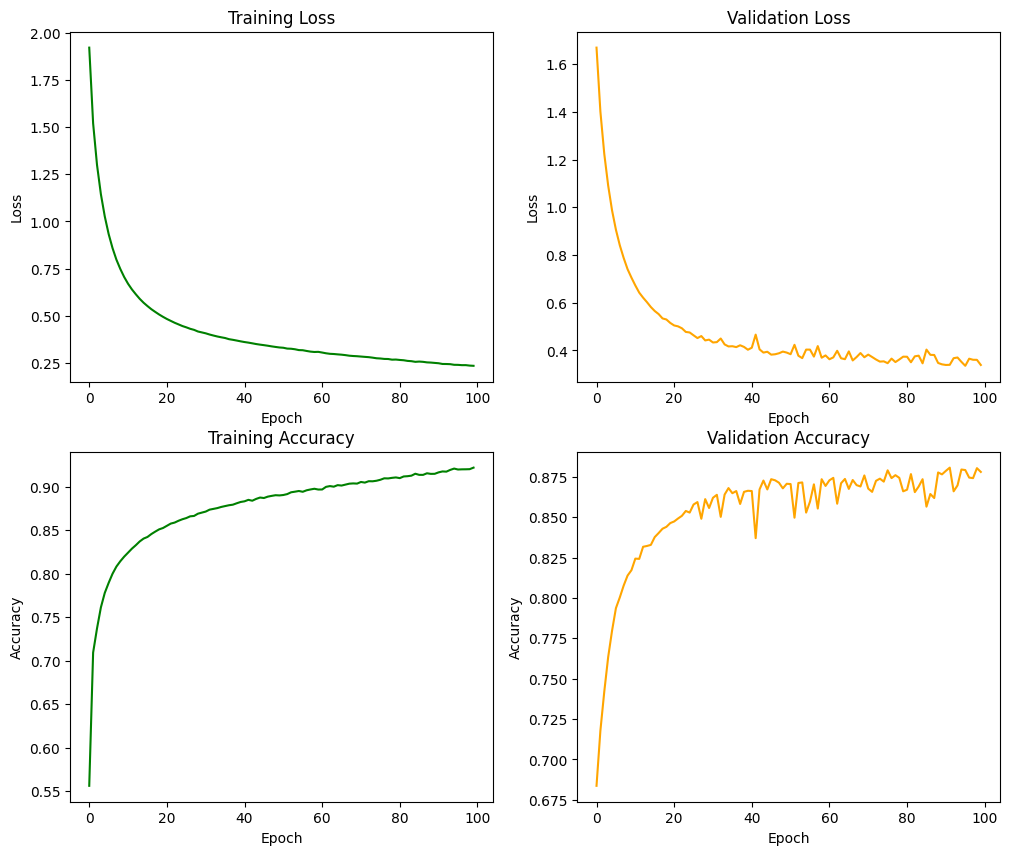

In [12]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
ax[0,0].plot(train_loss_list, color='green')
ax[0,0].set(title='Training Loss', xlabel='Epoch', ylabel='Loss')

ax[0,1].plot(val_loss_list, color='orange')
ax[0,1].set(title='Validation Loss', xlabel='Epoch', ylabel='Loss')

ax[1,0].plot(train_acc_list, color='green')
ax[1,0].set(title='Training Accuracy', xlabel='Epoch', ylabel='Accuracy')

ax[1,1].plot(val_acc_list, color='orange')
ax[1,1].set(title='Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')

plt.show()

## **4. Evaluation**

In [13]:
test_label = []
test_predict = []

model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    output = model(X_test)

    # transfer to CPU, currently it is tensor
    test_label.append(y_test.cpu())
    test_predict.append(output.cpu())

  test_label = torch.cat(test_label, dim=0)
  test_predict = torch.cat(test_predict, dim=0)
  test_acc = (torch.argmax(test_predict, dim=1) == test_label).sum().item()/len(test_label)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.8717


In [14]:
val_label = []
val_predict = []

model.eval()
with torch.no_grad():
  for X_val, y_val in val_loader:
    X_val, y_val = X_val.to(device), y_val.to(device)

    output = model(X_val)

    # transfer to CP, currently it is tensor
    val_label.append(y_val.cpu())
    val_predict.append(output.cpu())

  val_label = torch.cat(val_label, dim=0)
  val_predict = torch.cat(val_predict, dim=0)
  val_acc = (torch.argmax(val_predict, dim=1) == val_label).sum().item()/len(val_label)

print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.8780
